In [1]:
#importing libraries 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy
import pylab as pl
import statsmodels.api as sm
# import statsmodels as sm
from statsmodels.formula.api import ols
from functools import reduce
from scipy import stats


from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
from string import ascii_letters
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold



%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

98


/users/epepper/miniconda3/envs/micom/lib/python3.7/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


In [2]:
# pulling all omics from arivale data

#read in ASV table
asvs = pd.read_csv("/proj/arivale/microbiome/16S_processed/asvs.csv")

#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#read in taxonomy data
tax = pd.read_csv("/proj/arivale/microbiome/16S_processed/taxonomy.csv")

#load in chemistries snapshot 
chemistries = adi.get_snapshot('chemistries')

#load in metabolomics snapshot
metabolomics = adi.get_snapshot('metabolomics_corrected')
metabolomics_metadata = adi.get_snapshot('metabolomics_metadata')

#load in proteomics snapshot
proteomics = adi.get_snapshot('proteomics_corrected')

#load in anthropomics features
blood_pressure = adi.get_snapshot('blood_pressure')
saliva = adi.get_snapshot('saliva')
weight = adi.get_snapshot('weight')

#load in lifestyle_assessments snapshot  
lifestyle_assessment = adi.get_snapshot('assessments_raw')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

#import microbiome diversity
shannon_trimmed = adi.get_snapshot('microbiome_trimmed_diversity')
microbiome_diversity = adi.get_snapshot('microbiome_diversity')

#load in microbiome genera scaled counts
microbiome_genera = adi.get_snapshot('microbiome_genera')
microbiome_genera.shape

(5237, 918)

In [3]:
# view head size of dataframe containing all samples
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.head()
all_samples.shape

(5232, 24)

(2579, 25)

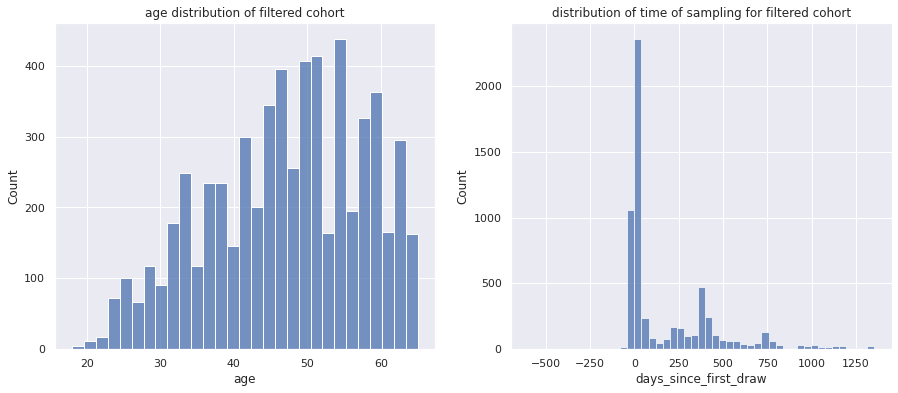

In [4]:
# filtering for age and antibiotic use and collecting baseline samples

#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=0]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# distribution of ages of samples retained
sns.histplot(ax=axes[0], x=age_filtered_samples['age'])
axes[0].set_title('age distribution of filtered cohort')

# distribution of days since first blood draw
sns.histplot(ax=axes[1], x=age_filtered_samples['days_since_first_draw'])
axes[1].set_title('distribution of time of sampling for filtered cohort')

fig.savefig('filtered_samples.png')

#filter for checkpoint1 samples (45 days or less)
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 45]
ckpt1_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
dups = baseline_samples.pivot_table(index = ['public_client_id'], aggfunc = 'size')
ckpt1_samples.shape

In [5]:
# converting metabolite id's to chemical names and pathways

metabolites = pd.DataFrame()
metabolites_in_use = pd.DataFrame()
metabolites_in_use['chemid'] = metabolomics.columns[8:].astype(int)
 

metabolites['metabolites'] = metabolomics_metadata['SUB_PATHWAY'] + ', ' + metabolomics_metadata['SUPER_PATHWAY'] + ', ' + metabolomics_metadata['BIOCHEMICAL_NAME']
metabolites = metabolites.replace(np.nan, 'Unannotated metabolite X')
metabolites['chemid'] = metabolomics_metadata['CHEMICAL_ID']
metabolites_measured = metabolites.merge(metabolites_in_use, how='inner', on='chemid')


mapping_dict = dict(zip(metabolites_measured.chemid.astype(str), metabolites_measured.metabolites))
metabolites_alone = metabolomics.iloc[:, 8:]
metabolites_meta = metabolomics.iloc[:, 0:8]
metabolites_alone = metabolites_alone.rename(columns=mapping_dict)

metabolomics = pd.concat([metabolites_meta, metabolites_alone], axis=1)
metabolomics.shape

(3305, 1304)

In [6]:
# number of rows in all 'omics datasets
print(' chemistries:', chemistries.shape[0], '\n', 'metabolomics:', metabolomics.shape, '\n', 
      'proteomics:', proteomics.shape[0], '\n', 'microbiome_diversity:', microbiome_diversity.shape[0], '\n',
      'microbiome_genera:', microbiome_genera.shape[0], '\n',
      'blood pressure:', blood_pressure.shape[0], '\n', 'saliva:', saliva.shape[0], '\n', 'weight:', weight.shape[0])

 chemistries: 11167 
 metabolomics: (3305, 1304) 
 proteomics: 6112 
 microbiome_diversity: 5237 
 microbiome_genera: 5237 
 blood pressure: 17243 
 saliva: 4151 
 weight: 262778


In [7]:
# getting baseline data for all omics dataframes, chosing a cutoff of 45 days or less from 'days since first draw'

# chemistries
baseline_chemistries = chemistries.copy(deep=True)
baseline_chemistries = chemistries[chemistries['days_since_first_draw'].abs() <= 45]

# metabolomics
baseline_metabolomics = metabolomics.copy(deep=True)
baseline_metabolomics = metabolomics[metabolomics['days_since_first_draw'].abs() <= 45]

# proteomics
baseline_proteomics = proteomics.copy(deep=True)
baseline_proteomics = proteomics[proteomics['days_since_first_draw'].abs() <= 45]

# microbiome diversity
baseline_diversity = microbiome_diversity.copy(deep=True)
baseline_diversity = microbiome_diversity[microbiome_diversity['days_since_first_draw'].abs() <= 45]

# microbiome diversity
baseline_genera = microbiome_genera.copy(deep=True)
baseline_genera = microbiome_genera[microbiome_genera['days_since_first_draw'].abs() <= 45]

# blood pressure
baseline_pressure = blood_pressure.copy(deep=True)
baseline_pressure = blood_pressure[blood_pressure['days_since_first_draw'].abs() <= 45]

# saliva
baseline_saliva = saliva.copy(deep=True)
baseline_saliva = saliva[saliva['days_since_first_draw'].abs() <= 45]

# weight
baseline_weight = weight.copy(deep=True)
baseline_weight = weight[weight['days_since_first_draw'].abs() <= 45]

print(' baseline chemistries:', baseline_chemistries.shape, '\n', 'baseline metabolomics:', baseline_metabolomics.shape, '\n', 
      'baseline proteomics:', baseline_proteomics.shape, '\n', 'baseline microbiome diversity:', baseline_diversity.shape, '\n',
      'baseline microbiome genera:', baseline_genera.shape, '\n',
      'baseline blood pressure:', baseline_pressure.shape, '\n', 'baseline saliva:', baseline_saliva.shape, '\n', 
      'baseline weight:', baseline_weight.shape)

 baseline chemistries: (4913, 140) 
 baseline metabolomics: (2038, 1304) 
 baseline proteomics: (2838, 1216) 
 baseline microbiome diversity: (3158, 37) 
 baseline microbiome genera: (3158, 918) 
 baseline blood pressure: (5979, 13) 
 baseline saliva: (2372, 14) 
 baseline weight: (29817, 14)


In [8]:
# this is just performing a check to make sure merging is working as expected

test_merge = baseline_chemistries.merge(baseline_proteomics, how='inner', on='public_client_id')
print('number of rows in test_merge:', test_merge.shape[0])

sameids = 0
for id1 in baseline_chemistries['public_client_id']:
    for id2 in baseline_proteomics['public_client_id']:
        if id1 == id2:
            sameids += 1
print('number of common ids in both dfs:', np.max(sameids))

dups = test_merge.pivot_table(index = ['public_client_id'], aggfunc = 'size')
dups = dups.sort_values()

sum_dups = 0
num_dups = 0
for value in dups:
    if value > 1:
        sum_dups += value
        num_dups += 1
print('number of duplicate ids in test_merge:', num_dups)
print('the sum of all duplicate ids is:', sum_dups)

list_cols = []
for col in test_merge.columns:
    list_cols.append(col)
# print(list_cols)

print('the number of unique ids in test_merge is:', test_merge['public_client_id'].nunique())
uniques = test_merge.drop_duplicates('public_client_id')
uniques.shape

# rm_dups = test_merge.drop_duplicates('public_client_id')

number of rows in test_merge: 2855
number of common ids in both dfs: 2855
number of duplicate ids in test_merge: 18
the sum of all duplicate ids is: 38
the number of unique ids in test_merge is: 2835


(2835, 1355)

In [9]:
###### Removing features from baseline dataframe that contain many NaN values

# choosing the cutoff. features retained will have (1 - cutoff) reported measurements
cutoff = 0.1

#Chemistries
# choosing only the columns that contain features
feat_chems = baseline_chemistries.iloc[:, 12:]
# creating dataframe with all features that do not meet the criteria
no_use_chems = feat_chems.columns[feat_chems.isnull().mean()>cutoff]
# dropping features that do not meet criteria
baseline_chemistries = baseline_chemistries.drop(no_use_chems, axis=1)
# printing number of features removed from dataframe
print('removing', len(no_use_chems), 'features from chemistries')

#Metabolomics
feat_metabs = baseline_metabolomics.iloc[:, 8:]
no_use_metabs = feat_metabs.columns[feat_metabs.isnull().mean()>cutoff]
baseline_metabolomics = baseline_metabolomics.drop(no_use_metabs, axis=1)
print('removing', len(no_use_metabs), 'features from metabolomics')

#Proteomics
feat_proteo = baseline_proteomics.iloc[:, 21:]
no_use_proteo = feat_proteo.columns[feat_proteo.isnull().mean()>cutoff]
baseline_proteomics = baseline_proteomics.drop(no_use_proteo, axis=1)
print('removing', len(no_use_proteo), 'features from proteomics')

#Microbiome Diversity
feat_micdiv = baseline_diversity.iloc[:, 11:]
no_use_micdiv = feat_micdiv.columns[feat_micdiv.isnull().mean()>cutoff]
baseline_diversity = baseline_diversity.drop(no_use_micdiv, axis=1)
print('removing', len(no_use_micdiv), 'features from microbiome diversity')

#Microbiome Genera
feat_gen = baseline_genera.iloc[:, 9:]
no_use_gen = feat_gen.columns[feat_gen.isnull().mean()>cutoff]
baseline_genera = baseline_genera.drop(no_use_gen, axis=1)
print('removing', len(no_use_gen), 'features from microbiome genera')

#Blood Pressure
feat_press = baseline_pressure.iloc[:, 8:]
no_use_press = feat_press.columns[feat_press.isnull().mean()>cutoff]
baseline_pressure = baseline_pressure.drop(no_use_press, axis=1)
print('removing', len(no_use_press), 'features from blood pressure')

#Saliva
feat_saliva = baseline_saliva.iloc[:, 8:]
no_use_saliva = feat_saliva.columns[feat_saliva.isnull().mean()>cutoff]
baseline_saliva = baseline_saliva.drop(no_use_saliva, axis=1)
print('removing', len(no_use_saliva), 'features from saliva')

#Weight
feat_weight = baseline_weight.iloc[:, 10:]
no_use_weight = feat_weight.columns[feat_weight.isnull().mean()>cutoff]
baseline_weight = baseline_weight.drop(no_use_weight, axis=1)
print('removing', len(no_use_weight), 'features from weight')

removing 89 features from chemistries
removing 562 features from metabolomics
removing 921 features from proteomics
removing 10 features from microbiome diversity
removing 0 features from microbiome genera
removing 1 features from blood pressure
removing 1 features from saliva
removing 1 features from weight


In [10]:
#Replacing all NaN values with the median of all values for that feature

# making a list of all columns
columns = baseline_chemistries.columns.tolist()
# for loop to replace all missing values with the median (median imputation)
for col in columns:
    baseline_chemistries[[col]] = baseline_chemistries[[col]].fillna(value=baseline_chemistries[[col]].median())
    
columns = baseline_metabolomics.columns.tolist()
for col in columns:
    baseline_metabolomics[[col]] = baseline_metabolomics[[col]].fillna(value=baseline_metabolomics[[col]].median())
    
columns = baseline_proteomics.columns.tolist()
for col in columns:
    baseline_proteomics[[col]] = baseline_proteomics[[col]].fillna(value=baseline_proteomics[[col]].median())

columns = baseline_diversity.columns.tolist()
for col in columns:
    baseline_diversity[[col]] = baseline_diversity[[col]].fillna(value=baseline_diversity[[col]].median())

columns = baseline_genera.columns.tolist()
for col in columns:
    baseline_genera[[col]] = baseline_genera[[col]].fillna(value=baseline_genera[[col]].median())

columns = baseline_pressure.columns.tolist()
for col in columns:
    baseline_pressure[[col]] = baseline_pressure[[col]].fillna(value=baseline_pressure[[col]].median())

columns = baseline_saliva.columns.tolist()
for col in columns:
    baseline_saliva[[col]] = baseline_saliva[[col]].fillna(value=baseline_saliva[[col]].median())
    
columns = baseline_weight.columns.tolist()
for col in columns:
    baseline_weight[[col]] = baseline_weight[[col]].fillna(value=baseline_weight[[col]].median())

In [11]:
# merging all baseline omics together

merge1 = baseline_chemistries.merge(baseline_metabolomics, how='inner', on='public_client_id')
merge2 = merge1.merge(baseline_proteomics, how='inner', on='public_client_id')
merge3 = merge2.merge(baseline_diversity, how='inner', on='public_client_id')
merge4 = merge3.merge(baseline_pressure, how='inner', on='public_client_id')
merge5 = merge4.merge(baseline_saliva, how='inner', on='public_client_id')
merge6 = merge5.merge(baseline_genera, how='inner', on='public_client_id')
baseline_omics = merge6.merge(baseline_weight, how='inner', on='public_client_id')

# dropping the columns that do not contain features or public client id
baseline_omics = baseline_omics.drop_duplicates(subset='public_client_id')
baseline_omics = baseline_omics.drop(['vendor_x', 'vendor_observation_id_x', 'observation_id_x', 'reflexive', 'fasting', 
                                      'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw_x', 'month_x', 
                                      'weekday_x', 'season_x', 'sample_id_x', 'days_in_program_y', 'days_since_first_call_y', 'days_since_first_draw_y',
                                      'month_y', 'weekday_y', 'season_y', 'sample_id_y', 'Chip_ID_CAM', 'Chip_ID_CRE', 'Chip_ID_CVD2', 
                                      'Chip_ID_CVD3', 'Chip_ID_DEV', 'Chip_ID_INF', 'Chip_ID_IRE', 'Chip_ID_MET', 'Chip_ID_NEU1', 'Chip_ID_NEX', 
                                      'Chip_ID_ODA', 'Chip_ID_ONC2', 'Chip_ID_ONC3', 'vendor_observation_id', 'vendor_y', 
                                      'client_id_y', 'vendor', 'observation_id_y'], axis=1)
# couting the number of columns retained across all baseline omics
list_of_cols = []
for col in baseline_omics.columns:
    list_of_cols.append(col)
print(len(list_of_cols))

1884


In [12]:
# this is the function that will calculate the delta for the selected feature, as well as the residuals
# of the delta, save a figure containing 6 plots showing useful information about the selected feature, 
# and finally save a csv file for each omics type (including all omics)

def get_deltas(df, feature_in_df, feature_name, unhealthy_range, is_greater_than):
    
    #filter for baseline chemistries
    ckpt1_chemistries = df[df['days_since_first_draw'].abs() <= 45]

    #merge with feature of interest data
    ckpt1_metadata = pd.merge(ckpt1_samples,ckpt1_chemistries[['public_client_id',f'{feature_in_df}']],on='public_client_id')

    #only include feature of interest levels below/above the healthy threshold
    if is_greater_than:
        ckpt1_metadata = ckpt1_metadata[ckpt1_metadata[f'{feature_in_df}'] >= unhealthy_range]
    else:
        ckpt1_metadata = ckpt1_metadata[ckpt1_metadata[f'{feature_in_df}'] <= unhealthy_range]

    #rename 'days since first draw' column to 'time point'
    ckpt1_metadata = ckpt1_metadata.rename(columns={'days_since_first_draw': 'time point'})

    #replace all values in the time point column with 0
    ckpt1_metadata['time point'] = np.where(ckpt1_metadata['time point'] <= 45, 0, 
                                                ckpt1_metadata['time point'])
    
    print('checkpoint 1 metadata shape is', ckpt1_metadata.shape)


    #filter for checkpoint2 samples (~6months)
    samples2 = age_filtered_samples.copy(deep=True)
    samples2['days_since_first_draw_abs'] = samples2['days_since_first_draw'].abs()
    samples2 = samples2[samples2['days_since_first_draw'].abs() <= 400]
    ckpt2_samples = samples2[samples2['days_since_first_draw'].abs() >180]
    ckpt2_samples = ckpt2_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
    #sixmonth_samples_ids = sixmonth_samples['id'].values
    
    print('checkpoint 2 sample shape is', ckpt2_samples.shape)


    #only indlude six month blood draw data for chemistries
    baseline_chemistries2 = df.copy(deep=True)
    baseline_chemistries2 = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() <= 400]
    ckpt2_chemistries = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() >180]
    ckpt2_chemistries.shape

    #merge with feature of interest data
    ckpt2_metadata = pd.merge(ckpt2_samples,ckpt2_chemistries[['public_client_id',f'{feature_in_df}']],
                              on='public_client_id')

    print('checkpoint 2 metadata shape is', ckpt2_metadata.shape)

    ckpt2_metadata = ckpt2_metadata.rename(columns={'days_since_first_draw': 'time point'})
    ckpt2_metadata['time point'] = np.where(ckpt2_metadata['time point'] <= 400, 6, 
                                                ckpt2_metadata['time point'])
    
    
    #convert bl_metadata from longform to wide form
    ckpt1long = pd.melt(ckpt1_metadata,id_vars=['public_client_id','time point'],value_vars=[f'{feature_in_df}'])
    ckpt1long = ckpt1long.drop(['variable'],axis=1)
    
    #convert sixmonth_metadata from longform to wide form
    ckpt2long = pd.melt(ckpt2_metadata,id_vars=['public_client_id','time point'],value_vars=[f'{feature_in_df}'])
    ckpt2long = ckpt2long.drop(['variable'],axis=1)


    #combine baseline and sixmonth metadata
    ckptALLlong = [ckpt1long,ckpt2long]
    ckptALLlongdata = pd.concat(ckptALLlong)
    ckptALLlongdata = ckptALLlongdata.rename(columns={'value':f'{feature_name}'})
    
    
    #rename feature column to 'BL_feature' in bl_metadata2 dataframe
    ckpt1_metadata2 = ckpt1_metadata.rename({'time point':'BL_time_point',
                                             f'{feature_in_df}':'BL_' + f'{feature_name}'},axis=1)
    
    print('checkpoint 1 metadata2 shape is', ckpt1_metadata2.shape)
    
    # rename 'feature' column to '2nd_feature' in sixmonth_metadata2 dataframe
    ckpt2_metadata2 = ckpt2_metadata.rename({'time point':'2nd_time_point',
                                             f'{feature_in_df}':'2nd_' + f'{feature_name}'},axis=1)
    
    print('checkpoint 2 metadata2 shape is', ckpt2_metadata2.shape)
    
    #create dataframe of baseline and 6 month feature data
    ckptALL_metadata = pd.merge(ckpt1_metadata2,ckpt2_metadata2[['public_client_id','2nd_time_point',
                                                                 '2nd_' + f'{feature_name}']], on='public_client_id')
    
    print('checkpoint for ALL in metadata shape is', ckptALL_metadata.shape)
#     ckptALL_metadata.to_csv(r'ckptALL_metadata.csv')

    print('checkpoint for ALL in metadata before unique selection', ckptALL_metadata.shape)


    ckptALL_metadata['public_client_id'].nunique()
    ckptALL_metadata.head()
    unique_ckptALL_metadata = ckptALL_metadata.drop_duplicates('public_client_id')
    unique_ckptALL_metadata['public_client_id'].nunique()
    
#     unique_ckptALL_metadata.to_csv('hba1c_metadata.csv')
    
    print('unique checkpoint for ALL in metadata shape is', unique_ckptALL_metadata.shape)
    
    ################################
    # DELTA CALCULATION
    ################################
    # create empty list for delta of feature
    Delta = []

    # create for loop that 
    for row1 in unique_ckptALL_metadata['BL_' + f'{feature_name}']:
        for row2 in unique_ckptALL_metadata['2nd_' + f'{feature_name}']:
            Delta.append(row2 - row1)
    
    # absolute value of delta        
    Delta_abs = [abs(ele) for ele in Delta]

    # add raw delta and abs column to BL and 6 month metadata
    num_rows = len(unique_ckptALL_metadata)
    unique_ckptALL_metadata['Raw Delta_' + f'{feature_name}'] = Delta[0:num_rows]
    unique_ckptALL_metadata['Delta_' + f'{feature_name}'] = Delta_abs[0:num_rows]
    
    
    # intermediate dataframe before normally distribution of delta values
    int_dataframe = unique_ckptALL_metadata.copy(deep=True)
    
    # add the minimum delta + 1 to all values, so that new min is equal to positive 1
    int_dataframe['Raw Delta_' + f'{feature_name}'] -= np.min(int_dataframe['Raw Delta_' + f'{feature_name}']) - 1
    new_min = np.min(int_dataframe['Raw Delta_' + f'{feature_name}'])
    
    no_zero = int_dataframe['Raw Delta_' + f'{feature_name}']
    
    # log transform the new deltas
    normal_delta = np.log10(no_zero)
    length = len(normal_delta)
    
    # save normalized deltas to the dataframe
    int_dataframe['Normalized Delta_' + f'{feature_name}'] = normal_delta[0:length]
    
    # drop samples where a delta could not be calculated
    no_na = int_dataframe.dropna(subset=['Normalized Delta_' + f'{feature_name}'])
    normalized_data = no_na.copy()
    
    print('normalized data retained after dropping NaN deltas:', normalized_data.shape[0])
    
    
    ##################################
    # LINEAR REGRESSION USING STATSMODELS - GETTING RESIDUALS FOR CONT MODELS
    ##################################
    
    # create objects to regress
    deltas = normalized_data['Normalized Delta_' + f'{feature_name}']
    baselines = normalized_data['BL_' + f'{feature_name}']
    
    # perform ordinary least squares linear regression
    delta_model = ols('deltas ~ baselines', data=normalized_data).fit()
    
    # get residuals
    continuous_residuals = delta_model.resid
    
    # influence
    influence = delta_model.get_influence()
    
    # standardized residuals
    standardized_residuals = influence.resid_studentized_internal
    
    #add residuals to table
    normalized_data['Cont_Residuals'] = continuous_residuals
    
    # add standardized residuals to data
    normalized_data[f'{feature_name}' + '_Residuals'] = standardized_residuals
    
    # removing residuals that are greater than 3 standard deviations away from the mean
    normalized_data = normalized_data[np.abs(normalized_data[f'{feature_name}' + '_Residuals'] - normalized_data[f'{feature_name}' + '_Residuals'].mean()) <= (3*normalized_data[f'{feature_name}' + '_Residuals'].std())]
    
    
    ##########################################################
    # merging normalized data with all baseline omics types
    ##########################################################
    
    filename = f'{feature_name}' + '/'
    
    normalized_data.to_csv(filename + f'{feature_name}_metrics.csv')
    
    # merging normalized data with all baseline omics
    deltas_ALL_BL_omics = pd.merge(baseline_omics, normalized_data[25:], how='inner', on='public_client_id')
    deltas_ALL_BL_omics = deltas_ALL_BL_omics.drop(['client_id_x', 'vendor_research', 'vendor_observation_id_y', 'vendor_dashboard',
                                                    'genome_id', 'genome_vendor', 'multiple_genome_ids', 'client_id', 'user_id', 
                                                    'sex', 'race', 'has_research_consent', 'enterprise', 'coach', 'region', 'country', 
                                                    'current_program', 'latest_program', 'is_helix', 'age', 'vendor_observation_id', 
                                                    'days_in_program', 'days_since_first_call', 'month', 'weekday', 'id', 
                                                    'meds_antibiotics_last_3_months'], axis=1)
    print('deltas v ALL omics:', deltas_ALL_BL_omics.shape)
    deltas_ALL_BL_omics.to_csv(filename + f'{feature_name}_v_ALL_BL_omics.csv')    
    
    # merging normalized data with baseline chemistries
    deltas_chemistries = pd.merge(baseline_chemistries, normalized_data[25:], how='inner', on='public_client_id')
    deltas_chemistries = deltas_chemistries.drop(['vendor', 'vendor_observation_id_x', 'observation_id', 
                                                  'reflexive', 'fasting', 'days_in_program_x', 'days_since_first_call_x', 
                                                  'days_since_first_draw', 'month_x', 'weekday_x', 'season', 'genome_id', 
                                                  'genome_vendor', 'multiple_genome_ids', 'client_id', 'user_id', 'sex', 
                                                  'race', 'has_research_consent', 'enterprise', 'coach', 'region', 'country', 
                                                  'current_program', 'latest_program', 'is_helix', 'age', 'vendor_observation_id_y', 
                                                  'days_in_program_y', 'days_since_first_call_y', 'month_y', 'weekday_y', 'id', 
                                                  'meds_antibiotics_last_3_months'], axis=1)
    print('deltas v chemistries:', deltas_chemistries.shape)
    deltas_chemistries.to_csv(filename + f'{feature_name}_v_chemistries.csv')
    
    # merging normalized data with baseline metabolomics
    deltas_metabolomics = pd.merge(baseline_metabolomics, normalized_data[25:], how='inner', on='public_client_id')
    deltas_metabolomics = deltas_metabolomics.drop(['sample_id', 'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw', 
                                                    'month_x', 'weekday_x', 'season', 'genome_id', 'genome_vendor', 'multiple_genome_ids', 
                                                    'client_id', 'user_id', 'sex', 'race', 'has_research_consent', 'enterprise', 'coach', 
                                                    'region', 'country', 'current_program', 'latest_program', 'is_helix', 'age', 
                                                    'vendor_observation_id', 'days_in_program_y', 'days_since_first_call_y', 'month_y', 
                                                    'weekday_y', 'id', 'meds_antibiotics_last_3_months'], axis=1)
    print('deltas v metabolomics:', deltas_metabolomics.shape)
    deltas_metabolomics.to_csv(filename + f'{feature_name}_v_metabolomics.csv')
    
    # merging normalized data with baseline proteomics
    deltas_proteomics = pd.merge(baseline_proteomics, normalized_data[25:], how='inner', on='public_client_id')
    deltas_proteomics = deltas_proteomics.drop(['sample_id', 'genome_id', 'genome_vendor', 'multiple_genome_ids', 'client_id', 'user_id', 
                                                'sex', 'race', 'has_research_consent', 'enterprise', 'coach', 'region', 'country', 
                                                'current_program', 'latest_program', 'is_helix', 'age', 'vendor_observation_id', 
                                                'days_in_program_y', 'days_since_first_call_y', 'month_y', 
                                                'weekday_y', 'id', 'meds_antibiotics_last_3_months', 'Chip_ID_CAM', 'Chip_ID_CRE', 
                                                'Chip_ID_CVD2', 'Chip_ID_CVD3', 'Chip_ID_DEV', 'Chip_ID_INF', 'Chip_ID_IRE', 'Chip_ID_MET', 
                                                'Chip_ID_NEU1', 'Chip_ID_NEX', 'Chip_ID_ODA', 'Chip_ID_ONC2', 'Chip_ID_ONC3', 
                                                'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw', 'month_x', 
                                                'weekday_x', 'season'], axis=1)
    print('deltas v proteomics:', deltas_proteomics.shape)
    deltas_proteomics.to_csv(filename + f'{feature_name}_v_proteomics.csv')
       
    # merging microbiome diversity and genera
    baseline_microbiome = pd.merge(baseline_diversity, baseline_genera, how='inner', on='public_client_id')
    baseline_microbiome = baseline_microbiome.drop_duplicates('public_client_id')
    
    # merging normalized data with baseline microbiome diversity
    deltas_microbiome = pd.merge(baseline_microbiome, normalized_data[25:], how='inner', on='public_client_id')
    deltas_microbiome = deltas_microbiome.drop(['vendor_observation_id_x', 'vendor_dashboard', 'client_id_x', 'vendor_research', 
                                                'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw_x', 'month_x', 
                                                'weekday_x', 'season_x', 'vendor_observation_id_y', 'vendor', 'days_in_program_y', 
                                                'days_since_first_call_y', 'days_since_first_draw_y', 'month_y', 'weekday_y', 
                                                'season_y', 'genome_id', 'genome_vendor', 'multiple_genome_ids', 'client_id_y', 
                                                'user_id', 'sex', 'race', 'has_research_consent', 'enterprise', 'coach', 'region', 
                                                'country', 'current_program', 'latest_program', 'is_helix', 'age', 'vendor_observation_id', 
                                                'days_in_program', 'days_since_first_call', 'month_y', 
                                                'weekday_y', 'id', 'meds_antibiotics_last_3_months', 'month', 'weekday'], axis=1)
    print('deltas v microbiome:', deltas_microbiome.shape)
    deltas_microbiome.to_csv(filename + f'{feature_name}_v_microbiome.csv')
    
    
    # merging saliva, blood pressure, and weight metrics
    baseline_anthro = pd.merge(baseline_saliva, baseline_pressure, how='inner', on='public_client_id')
    baseline_anthro = pd.merge(baseline_anthro, baseline_weight, how='inner', on='public_client_id')
    baseline_anthro = baseline_anthro.drop_duplicates('public_client_id')
    
    # merging normalized data with baseline anthropomics metrics
    deltas_anthro = pd.merge(baseline_anthro, normalized_data[25:], how='inner', on='public_client_id')
    deltas_anthro = deltas_anthro.drop(['vendor_x', 'days_in_program_x', 'days_since_first_call_x', 'days_since_first_draw_x', 
                                        'month_x', 'weekday_x', 'season_x', 'vendor_y', 'days_in_program_y', 
                                        'days_since_first_call_y', 'days_since_first_draw_y', 'month_y', 'weekday_y', 'season_y', 
                                        'client_id_x', 'vendor', 'observation_id', 'days_in_program_x', 'days_since_first_call_x', 
                                        'days_since_first_draw', 'month_x', 'weekday_x', 'season', 'genome_id', 'genome_vendor', 
                                        'multiple_genome_ids', 'client_id_y', 'user_id', 'sex', 'race', 'has_research_consent', 
                                        'enterprise', 'coach', 'region', 'country', 'current_program', 'latest_program', 'is_helix', 
                                        'age', 'vendor_observation_id', 'days_in_program_y', 'days_since_first_call_y', 'month_y', 
                                        'weekday_y', 'id', 'meds_antibiotics_last_3_months'], axis=1)
    
    print('deltas v anthro:', deltas_anthro.shape)
    deltas_anthro.to_csv(filename + f'{feature_name}_v_anthro.csv')
    
    ##################################
    # Figures
    ##################################
    
    x_bound_label = unique_ckptALL_metadata['BL_' + f'{feature_name}'].max() - 20
    label = 'mean = ' + unique_ckptALL_metadata['BL_' + f'{feature_name}'].mean().astype(str) + '\n' + 'median = ' + unique_ckptALL_metadata['BL_' + f'{feature_name}'].median().astype(str)

    fig, axes = plt.subplots(4, 2, figsize=(15, 24))
    
    # histogram of baseline values for feature
    sns.histplot(ax=axes[0, 0], x=unique_ckptALL_metadata['BL_' + f'{feature_name}'])
    axes[0, 0].set_title('Baseline ' + f'{feature_name}' + ' across samples')
    
    # change in feature of interest levels between two checkpoints
    sns.pointplot(ax=axes[0, 1], x='time point',y=f'{feature_name}',data=ckptALLlongdata)
    axes[0, 1].set_title('average change in ' + f'{feature_name}')
    
    # histogram of delta values for feature
    sns.histplot(ax=axes[1, 0], x=int_dataframe['Delta_' + f'{feature_name}'])
    axes[1, 0].set_title('Delta ' + f'{feature_name}')
    
    # histogram of log transformed delta values for feature
    sns.histplot(ax=axes[1, 1], x=normal_delta)
    axes[1, 1].set_title('Log Transformed Delta ' + f'{feature_name}')
    
    # baseline values against deltas
    sns.scatterplot(ax=axes[2, 0], data=normalized_data, x='BL_' + f'{feature_name}', y='Delta_' + f'{feature_name}')
    axes[2, 0].set_title('Baseline ' + f'{feature_name}' + ' vs ' + 'Delta ' + f'{feature_name}')
    
    # baseline values against normalized deltas
    sns.scatterplot(ax=axes[2, 1], data=normalized_data, x='BL_' + f'{feature_name}', y='Normalized Delta_' + f'{feature_name}')
    axes[2, 1].set_title('Baseline ' + f'{feature_name}' + ' vs ' + 'Normalized Delta ' + f'{feature_name}')
    
    # continuous residuals
    sns.histplot(ax=axes[3, 0], x=normalized_data['Cont_Residuals'])
    axes[3, 0].set_title('Contiuous Residuals')
    
    # standardized residuals
    sns.histplot(ax=axes[3, 1], x=normalized_data[f'{feature_name}' + '_Residuals'])
    axes[3, 1].set_title('Standardized Residuals')
    
    plt.savefig(filename + f'{feature_name}' + '_get_deltas')

checkpoint 1 metadata shape is (2577, 27)
checkpoint 2 sample shape is (695, 25)
checkpoint 2 metadata shape is (881, 27)
checkpoint 1 metadata2 shape is (2577, 27)
checkpoint 2 metadata2 shape is (881, 27)
checkpoint for ALL in metadata shape is (731, 29)
checkpoint for ALL in metadata before unique selection (731, 29)
unique checkpoint for ALL in metadata shape is (552, 29)
normalized data retained after dropping NaN deltas: 549
deltas v ALL omics: (379, 1890)
deltas v chemistries: (522, 50)
deltas v metabolomics: (405, 640)
deltas v proteomics: (456, 285)
deltas v microbiome: (521, 936)
deltas v anthro: (445, 23)


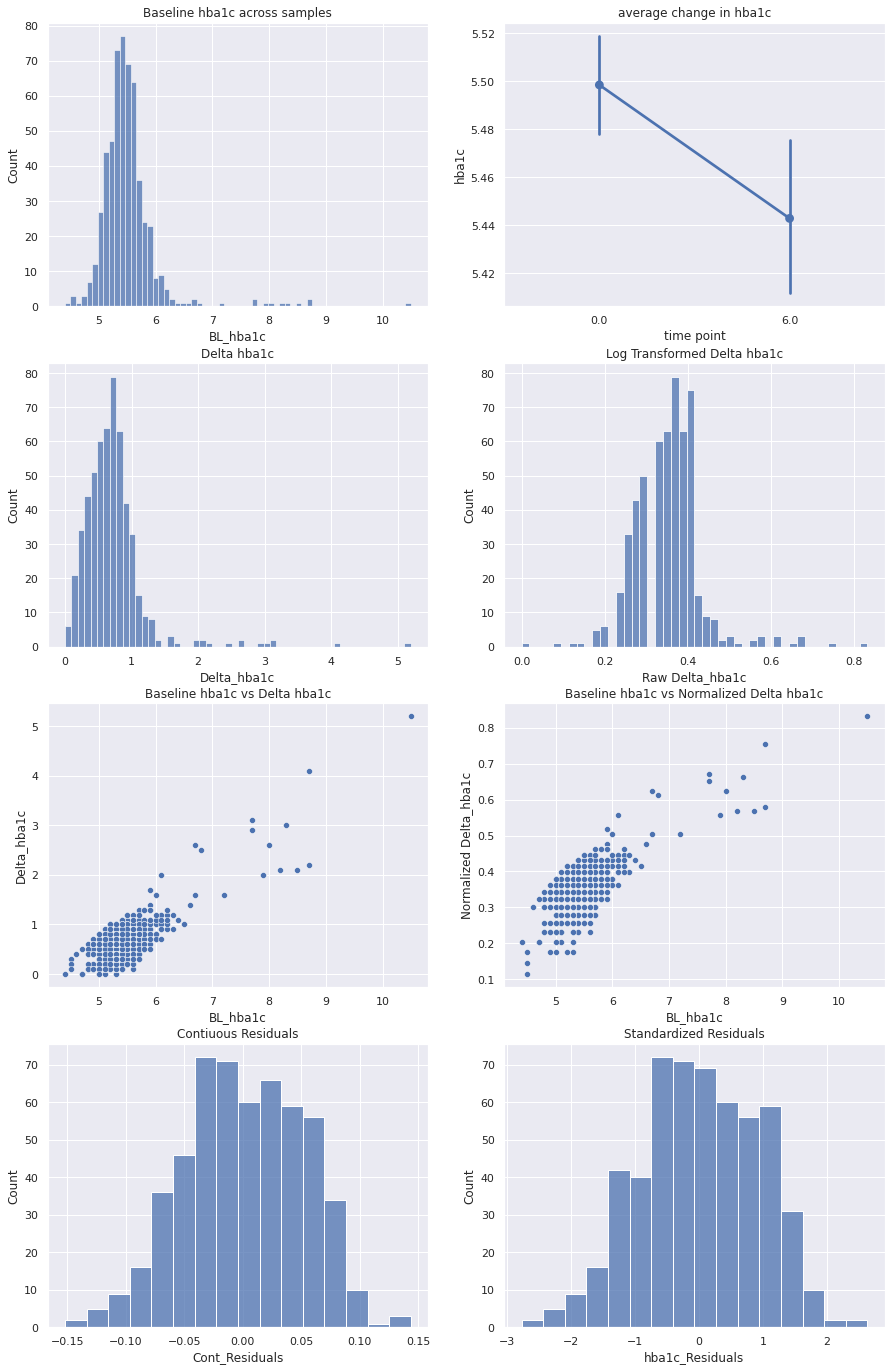

In [13]:
# agruments are as follows:
# 1. name of snapshot containing feature that was initialized at beginning of notebook
# 2. column title for feature of interest
# 3. abbreviated title to use throughout, MUST BE SAME AS DIRECTORY NAME
# 4. numerical threshold for unhealthy group, use 0.0 to include all samples
# 5. if True, unhealthy range is ABOVE threshold value, if False, unhealthy range is BELOW threshold value

# listed below are features that have been observed, and if known, their corresponding threshold at which if above or below, 
# subject is considered unhealthy for feature

# clinically relevant features
# BMI, 27.5, True
# Diastolic BP
# Calcium, 9.9, True
# Cholesterol Total, 200, True
# Glucose, 85.0, True
# HbA1c, 5.0, True
# HDL Cholesterol, 70.0, False
# HDL Particle Number, 30.5, False
# Homocysteine, ??
# Insulin, 29.0, True
# LDL Cholesterol, ??, True
# LDL Particle Number, 980, True
# Omega 6/Omega 3 Ratio
# Red Cell Count
# Sodium
# Systolic BP
# Triglycerides, 149, True
# Triglycerides HDL Ratio
# Weight

# microbiome features listed below
# chao1 50000, 1500, True
# microbiome diversity score
# observed otus 100000
# shannon 100000

# call the function on the feature of interest
get_deltas(chemistries, 'GLYCOHEMOGLOBIN A1C', 'hba1c', 0.0, True)

In [14]:
cols = []
for column in chemistries.columns:
    cols.append(column)
print(cols)

['public_client_id', 'vendor', 'vendor_observation_id', 'observation_id', 'reflexive', 'fasting', 'days_in_program', 'days_since_first_call', 'days_since_first_draw', 'month', 'weekday', 'season', 'A/G RATIO', 'ADIPONECTIN, SERUM', 'ALAT (SGPT)', 'ALBUMIN', 'ALKALINE PHOSPHATASE', 'ANTIOXID CAP, TOTAL', 'ARACHIDONIC ACID', 'ARSENIC, BLOOD', 'ASAT (SGOT)', 'BASOPHILS', 'BASOPHILS ABSOLUTE', 'BILIRUBIN, DIRECT', 'BILIRUBIN, INDIRECT', 'BILIRUBIN, TOTAL', 'BUN/CREAT RATIO', 'CALCIUM', 'CARBON DIOXIDE (CO2)', 'CHLORIDE', 'CHOLESTEROL, TOTAL', 'COPPER, RBC', 'CREATININE ENZ, SER', 'CRP HIGH SENSITIVITY', 'DHA', 'DPA', 'EOSINOPHILS', 'EOSINOPHILS ABSOLUTE', 'EPA', 'EPA/AA', 'FERRITIN', 'FOLIC ACID, SERUM', 'GFR, MDRD', 'GFR, MDRD, AFRICAN AM', 'GGT', 'GLOBULIN', 'GLUCOSE', 'GLUTATHIONE, TOTAL', 'GLYCOHEMOGLOBIN A1C', 'HDL CHOL DIRECT', 'HDL LARGE', 'HDL PARTICLE NUMBER', 'HDL PARTICLE PERCENTILE', 'HDL SIZE PERCENTILE', 'HEMATOCRIT', 'HEMOGLOBIN', 'HOMA-IR', 'HOMOCYSTEINE, SERUM', 'IDL PARTI

In [15]:
resid_div = pd.read_csv('hba1c/hba1c_v_microbiome.csv')
which_vendor = pd.merge(resid_div[['public_client_id', 'observed_otus_30000', 'hba1c_Residuals']], baseline_diversity[['vendor_dashboard', 'public_client_id']], how='inner', on='public_client_id')
which_vendor

,public_client_id,observed_otus_30000,hba1c_Residuals,vendor_dashboard
0,01040480,615.6,-1.981144,research-microbiome
1,01044249,581.3,-0.305688,research-microbiome
2,01045282,996.5,-0.106244,Second Genome
3,01048300,498.3,-0.702865,research-microbiome
4,01053354,676.0,-2.336924,research-microbiome
...,...,...,...,...
516,HX591749,503.0,0.417907,research-microbiome
517,HX639632,606.4,-0.330601,research-microbiome
518,HX848290,665.0,-0.295674,research-microbiome
519,HX850312,569.3,0.557809,research-microbiome


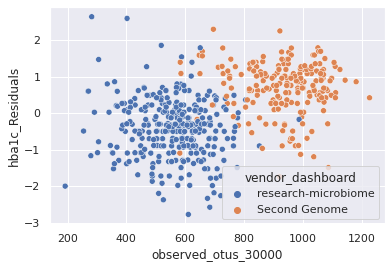

In [16]:
vendor = sns.scatterplot(data=which_vendor, x='observed_otus_30000', y='hba1c_Residuals', hue='vendor_dashboard')
fig1 = vendor.get_figure()
fig1.savefig('which_vendor.png')

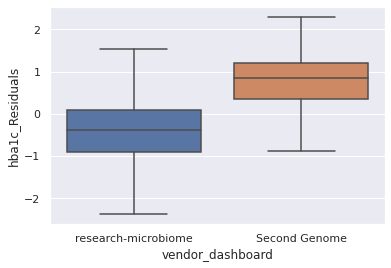

In [17]:
vendor2 = sns.boxplot(x='vendor_dashboard', y='hba1c_Residuals', data=which_vendor, showfliers=False)
fig2 = vendor2.get_figure()
fig2.savefig('which_vendor_2.png')

In [18]:
pd.set_option('display.max_columns', None)
new_metabolomics = adi.get_snapshot('metabolomics_corrected')
new_metabolomics

public_client_id      sample_id  days_in_program  days_since_first_call  \
0            01000261  A477AV558-002               65                   -9.0   
1            01001621  A391BM948-002              265                  223.0   
2            01001621  A776BI445-003               11                  -31.0   
3            01002183  A595AV320-002               13                   -1.0   
4            01002412  A294AU415-002               13                   -6.0   
...               ...            ...              ...                    ...   
3300         HX409129  A581BK409-002                5                    2.0   
3301         HX460562  A641BO324-003               28                    7.0   
3302         HX794171  A229BM682-002               56                  -17.0   
3303             INEW  A750AX220-002              149                  106.0   
3304             MUMA  A803AW467-002              120                   75.0   

      days_since_first_draw month weekday  season        35        50  \
0                         0   Jan     Tue  winter  0.972222  2.568898   
1                       254   Apr     Wed  spring  1.819302  0.704097   
2                         0   Jul     Mon  summer  2.540378  0.568236   
3                         0   Jan     Wed  winter  0.528804  2.260729   
4                         0   Nov     Thu    fall  0.863152  0.535317   
...                     ...   ...     ...     ...       ...       ...   
3300                      0   Dec     Fri  winter  0.293945  1.169026   
3301                      0   Aug     Thu  summer  0.967099  1.137992   
3302                      0   Mar     Fri  spring  0.847237  0.739835   
3303                    142   Mar     Fri  spring       NaN  2.187877   
3304                    -21   Feb     Wed  winter  0.812045  0.971784   

            55        62        71        93        98       111       112  \
0     1.155771  0.824435  1.666061  0.947589  0.772955  0.716831  1.193115   
1     0.619724  1.014908  2.101260  1.334809  1.341022  0.971382       NaN   
2     1.328050       NaN  1.003031  1.366908  0.967574  1.957150  0.928533   
3     0.425073  2.299795  1.940374  0.850577  1.737810       NaN  2.335956   
4     1.008430  1.300685  1.223568  0.877139  0.772371  1.052063  1.128991   
...        ...       ...       ...       ...       ...       ...       ...   
3300  2.116840  0.888013       NaN       NaN  0.685195  2.681062  0.842799   
3301  1.731506  0.676390       NaN  0.804149  1.313167  1.003930  0.842896   
3302  0.660610  0.742720  0.729642       NaN  1.022540       NaN  0.892882   
3303  1.635473  0.793053  1.023138  0.826271  2.112935  1.446977  1.236833   
3304  1.474707  0.394527  1.262915  2.734523  1.366411  1.256579  1.211834   

           117       132        136       144       158       171       179  \
0     1.265563  5.372793  24.532961  1.615655  1.289964  1.135706  0.815813   
1     1.302103  0.437747   0.597480  1.363197  0.981717  0.373895  2.085763   
2     1.164143  0.456719   1.732912       NaN  1.103766  0.893238       NaN   
3     2.452279  3.769524   3.896395  1.492480  1.051881  1.459102  1.823657   
4     1.649449  1.276539   0.338884       NaN  0.912151  1.371908  0.993805   
...        ...       ...        ...       ...       ...       ...       ...   
3300       NaN  1.212464   0.191386  1.065424  0.924692  1.498795  0.775644   
3301       NaN  1.034660   4.892710       NaN  1.349325  0.590254  0.773872   
3302  0.829422  0.556806   1.020689  1.688183  1.271883  0.908899  0.562607   
3303  1.058925  2.500101   4.786991       NaN  0.888386  2.051927  0.436781   
3304  1.467920  2.588349   0.290345       NaN  0.800763  1.896884  0.420819   

           180       181       182       189       192       194       197  \
0     0.710183  0.986860  0.603223  1.421159  1.128161  1.186826  1.186918   
1     0.567837  0.650733       NaN  1.036290  0.888782  1.192718  0.666124   
2          NaN  1.504583  0.851745       NaN  0

In [19]:
df_metabolites = new_metabolomics.drop(['public_client_id', 'days_in_program', 'days_since_first_call', 'days_since_first_draw', 
                                        'month', 'weekday', 'season'], axis=1)
df_metabolites = df_metabolites.fillna(0)
df_metabolites

sample_id        35        50        55        62        71  \
0     A477AV558-002  0.972222  2.568898  1.155771  0.824435  1.666061   
1     A391BM948-002  1.819302  0.704097  0.619724  1.014908  2.101260   
2     A776BI445-003  2.540378  0.568236  1.328050  0.000000  1.003031   
3     A595AV320-002  0.528804  2.260729  0.425073  2.299795  1.940374   
4     A294AU415-002  0.863152  0.535317  1.008430  1.300685  1.223568   
...             ...       ...       ...       ...       ...       ...   
3300  A581BK409-002  0.293945  1.169026  2.116840  0.888013  0.000000   
3301  A641BO324-003  0.967099  1.137992  1.731506  0.676390  0.000000   
3302  A229BM682-002  0.847237  0.739835  0.660610  0.742720  0.729642   
3303  A750AX220-002  0.000000  2.187877  1.635473  0.793053  1.023138   
3304  A803AW467-002  0.812045  0.971784  1.474707  0.394527  1.262915   

            93        98       111       112       117       132        136  \
0     0.947589  0.772955  0.716831  1.193115  1.265563  5.372793  24.532961   
1     1.334809  1.341022  0.971382  0.000000  1.302103  0.437747   0.597480   
2     1.366908  0.967574  1.957150  0.928533  1.164143  0.456719   1.732912   
3     0.850577  1.737810  0.000000  2.335956  2.452279  3.769524   3.896395   
4     0.877139  0.772371  1.052063  1.128991  1.649449  1.276539   0.338884   
...        ...       ...       ...       ...       ...       ...        ...   
3300  0.000000  0.685195  2.681062  0.842799  0.000000  1.212464   0.191386   
3301  0.804149  1.313167  1.003930  0.842896  0.000000  1.034660   4.892710   
3302  0.000000  1.022540  0.000000  0.892882  0.829422  0.556806   1.020689   
3303  0.826271  2.112935  1.446977  1.236833  1.058925  2.500101   4.786991   
3304  2.734523  1.366411  1.256579  1.211834  1.467920  2.588349   0.290345   

           144       158       171       179       180       181       182  \
0     1.615655  1.289964  1.135706  0.815813  0.710183  0.986860  0.603223   
1     1.363197  0.981717  0.373895  2.085763  0.567837  0.650733  0.000000   
2     0.000000  1.103766  0.893238  0.000000  0.000000  1.504583  0.851745   
3     1.492480  1.051881  1.459102  1.823657  2.978882  2.421741  1.466470   
4     0.000000  0.912151  1.371908  0.993805  1.363787  1.691931  1.149111   
...        ...       ...       ...       ...       ...       ...       ...   
3300  1.065424  0.924692  1.498795  0.775644  1.463832  1.410570  0.741907   
3301  0.000000  1.349325  0.590254  0.773872  0.660153  0.810674  2.134438   
3302  1.688183  1.271883  0.908899  0.562607  1.606326  1.081211  0.566162   
3303  0.000000  0.888386  2.051927  0.436781  0.904626  1.013039  1.232329   
3304  0.000000  0.800763  1.896884  0.420819  1.101575  1.203452  0.972805   

           189       192       194       197       207       209       212  \
0     1.421159  1.128161  1.186826  1.186918  1.154610  2.183882  1.129249   
1     1.036290  0.888782  1.192718  0.666124  0.959918  1.047442  1.219334   
2     0.000000  0.802254  1.359346  0.408849  1.004298  1.213243  1.080032   
3     1.207379  1.758998  1.133902  1.520067  1.259921  1.886599  1.093981   
4     1.695642  1.353985  0.946088  0.739603  1.199903  0.837236  1.219042   
...        ...       ...       ...       ...       ...       ...       ...   
3300  0.754003  0.000000  0.000000  0.853879  0.953365  0.985995  0.884191   
3301  1.411470  0.812872  1.117198  1.053634  1.144151  0.901961  1.180933   
3302  0.842122  0.921913  1.014110  0.813691  1.168369  0.263425  0.852257   
3303  3.505438  0.811308  0.900621  1.412596  1.000000  1.981013  0.720299   
3304  0.996129  1.776075  0.957674  1.661142  1.495418  0.000000  0.000000   

           229       231       234       235       240       241       244  \
0     0.920111  1.374374  1.891255  0.819227  1.204927  1.203517  1.017136   
1     0.663285  1.661423  0.694435  2.090090  1.321783  0.546186  0.927013   
2     0.844420  1.254205  0.603340  1.733442  1.165452  1.508164  1.460673  

In [20]:
new_chemistries = adi.get_snapshot('chemistries')
new_chemistries

,public_client_id,vendor,vendor_observation_id,observation_id,reflexive,fasting,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,A/G RATIO,"ADIPONECTIN, SERUM",ALAT (SGPT),ALBUMIN,ALKALINE PHOSPHATASE,"ANTIOXID CAP, TOTAL",ARACHIDONIC ACID,"ARSENIC, BLOOD",ASAT (SGOT),BASOPHILS,BASOPHILS ABSOLUTE,"BILIRUBIN, DIRECT","BILIRUBIN, INDIRECT","BILIRUBIN, TOTAL",BUN/CREAT RATIO,CALCIUM,CARBON DIOXIDE (CO2),CHLORIDE,"CHOLESTEROL, TOTAL","COPPER, RBC","CREATININE ENZ, SER",CRP HIGH SENSITIVITY,DHA,DPA,EOSINOPHILS,EOSINOPHILS ABSOLUTE,EPA,EPA/AA,FERRITIN,"FOLIC ACID, SERUM","GFR, MDRD","GFR, MDRD, AFRICAN AM",GGT,GLOBULIN,GLUCOSE,"GLUTATHIONE, TOTAL",GLYCOHEMOGLOBIN A1C,HDL CHOL DIRECT,HDL LARGE,HDL PARTICLE NUMBER,HDL PARTICLE PERCENTILE,HDL SIZE PERCENTILE,HEMATOCRIT,HEMOGLOBIN,HOMA-IR,"HOMOCYSTEINE, SERUM",IDL PARTICLE NUMBER,IL-6,IL-8,IMMATURE GRANULOCYTES,IMMATURE GRANULOCYTES ABSOLUTE,INSULIN,LACTIC DEHYDROGENASE,LARGE HDL PARTICLE PERCENTILE,LARGE LDL PARTICLE NUMBER,LARGE MED HDL PARTICLE NUMBER,LARGE MED VLDL PARTICLE NUMBER,LARGE VLDL PARTICLE PERCENTILE,LDL MEDIUM,LDL PARTICLE NUMBER,LDL PEAK SIZE,LDL SIZE PERCENTILE,LDL SMALL,LDL-CHOL CALCULATION,LDL_SIZE,"LEAD, BLOOD",LINOLEIC_ACID,LPIR SCORE PERCENTILE,LPIR_SCORE,LP_PLA2,LYMPHOCYTES,LYMPHOCYTES ABSOLUTE,"MAGNESIUM, SERUM","MANGANESE, SERUM",MCH,MCHC,MCV,MEDIUM HDL PARTICLE NUMBER,MEDIUM VLDL PARTICLE NUMBER,"MERCURY, BLOOD",METHYLMALONIC ACID,MONOCYTES,MONOCYTES ABSOLUTE,MPV,"NEUTROPHIL, SEGS",NEUTROPHILS ABSOLUTE,OMEGA-3 INDEX,OMEGA-6/OMEGA-3 RATIO,OMEGA_3_TOTAL,OMEGA_6_TOTAL,OXLDL,"PAI-1 ANTIGEN, QNT",PFFA,PHOSPHORUS INORGANIC,PLATELET COUNT,PLATELET COUNT THOUSAND,POTASSIUM,PROT AND PFFA CALC,PROTEIN,"PROTEIN, TOTAL SERUM",QUICKI,RDW,RED CELL COUNT,"SELENIUM, SERUM",SMALL HDL PARTICLE NUMBER,SMALL LDL PARTICLE PERCENTILE,SMALL VLDL PARTICLE NUMBER,SODIUM,SUPEROX DISMUT SOD,TNF-ALPHA,TOTAL NEUTROPHILS,TOTAL NEUTROPHILS AB,TRIGLYCERIDES,Triglyceride HDL Ratio,UREA NITROGEN,URIC ACID,"VITAMIN D, 25-OH TOT","VITAMIN D2, 25-OH","VITAMIN D3, 25-OH",VLDL LDL PARTICLE NUMBER,VLDL PARTICLE NUMBER,VLDL SIZE PERCENTILE,VLDL TRIGLYCERIDES,WHITE CELL COUNT,ZINC,"ZINC, RBC",leptin,zinc_plasma_or_serum
0,01000261,Quest,YH289668,10271,False,TRUE,65,-9.0,0,Jan,Tue,winter,2.0,10.4,12.0,4.5,43.0,1895.3,8.0,2.0,15.0,0.3,0.02,0.1,0.4,0.5,18.0,9.4,25.0,101.0,232.0,0.67,0.65,0.20,3.0,NaN,1.9,0.11,0.9,0.1125,63.0,16.3,97.0,NaN,13.0,2.2,90.0,950.0,5.1,67.0,8342.0,NaN,NaN,NaN,45.0,14.5,2.222222,9.1,NaN,1.62,8.75,NaN,NaN,10.0,131.0,NaN,NaN,NaN,NaN,NaN,528.0,1807.0,219.3,NaN,228.0,142.0,NaN,1.2,NaN,NaN,NaN,NaN,16.7,0.98,NaN,0.5,29.7,32.2,92.0,NaN,NaN,2.0,83.0,1.5,0.09,10.1,79.6,4.68,4.0,7.3,NaN,NaN,NaN,108.2,NaN,3.1,244000.0,244.0,4.2,NaN,NaN,6.7,0.147007,13.8,4.90,140.0,NaN,NaN,NaN,136.0,66.6,1.9,79.6,4.68,114.0,1.701493,12.0,4.1,58.0,4.0,58.0,NaN,NaN,NaN,NaN,5.9,980.0,9.8,NaN,NaN
1,01000261,LCA,B0040998784,65656,False,TRUE,198,124.0,133,May,Tue,spring,2.0,12.4,12.0,4.3,40.0,NaN,8.8,NaN,18.0,0.0,0.00,NaN,NaN,0.6,12.0,9.6,22.0,99.0,230.0,NaN,0.77,0.14,3.0,1.1,2.0,0.10,0.9,NaN,69.0,19.9,91.0,105.0,9.0,2.1,90.0,287.0,5.5,68.0,NaN,32.7,63.5,54.4,42.8,14.6,1.222222,9.8,246.0,0.70,11.30,0.0,0.0,5.5,NaN,86.6,867.0,16.5,36.2,24.9,NaN,1742.0,NaN,90.6,447.0,141.0,21.4,1.0,24.1,22.5,25.0,174.0,24.0,1.20,1.6,NaN,30.4,34.1,89.0,6.1,37.0,2.8,115.0,4.0,0.20,NaN,NaN,NaN,5.0,7.2,5.0,36.0,42.0,NaN,93.0,NaN,NaN,247.0,4.2,626.0,533.0,6.4,NaN,12.9,4.81,NaN,16.0,42.0,10.0,138.0,NaN,0.9,70.0,3.40,107.0,1.573529,9.0,4.2,55.3,NaN,NaN,1753.0,45.5,48.9,69.1,4.9,1410.0,NaN,NaN,NaN
2,01001298,LCA,AV27365801,2837393,False,TRUE,7,0.0,0,Sep,Tue,fall,1.8,NaN,25.0,4.2,63.0,NaN,11.7,NaN,28.0,NaN,NaN,NaN,NaN,0.3,18.0,9.0,24.0,101.0,271.0,NaN,0.68,0.60,3.0,1.2,NaN,NaN,1.2,NaN,57.0,NaN,95.0,109.0,15.0,2.4,94.0,NaN,5.6,64.0,NaN,35.7,NaN,NaN,NaN,NaN,1.601481,7.5,NaN,NaN,NaN,NaN,NaN,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2307.0,NaN,NaN,893.0,187.0,21.5,NaN,25.0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [21]:
on_vendor = pd.merge(new_metabolomics, new_chemistries, how='inner', on='public_client_id')
new_on_vendor = on_vendor[['sample_id', 'vendor']]
# new_on_vendor.set_index(on_vendor['sample_id'],inplace=True)
new_on_vendor

,sample_id,vendor
0,A477AV558-002,Quest
1,A477AV558-002,LCA
2,A391BM948-002,LCA
3,A391BM948-002,LCA
4,A776BI445-003,LCA
...,...,...
11222,A750AX220-002,Quest
11223,A750AX220-002,LCA
11224,A803AW467-002,LCA
11225,A803AW467-002,LCA


In [22]:
final_merge = pd.merge(new_on_vendor, df_metabolites, how='inner', on='sample_id')
final_merge

sample_id vendor        35        50        55        62        71  \
0      A477AV558-002  Quest  0.972222  2.568898  1.155771  0.824435  1.666061   
1      A477AV558-002    LCA  0.972222  2.568898  1.155771  0.824435  1.666061   
2      A391BM948-002    LCA  1.819302  0.704097  0.619724  1.014908  2.101260   
3      A391BM948-002    LCA  1.819302  0.704097  0.619724  1.014908  2.101260   
4      A776BI445-003    LCA  2.540378  0.568236  1.328050  0.000000  1.003031   
...              ...    ...       ...       ...       ...       ...       ...   
11222  A750AX220-002  Quest  0.000000  2.187877  1.635473  0.793053  1.023138   
11223  A750AX220-002    LCA  0.000000  2.187877  1.635473  0.793053  1.023138   
11224  A803AW467-002    LCA  0.812045  0.971784  1.474707  0.394527  1.262915   
11225  A803AW467-002    LCA  0.812045  0.971784  1.474707  0.394527  1.262915   
11226  A803AW467-002    LCA  0.812045  0.971784  1.474707  0.394527  1.262915   

             93        98       111       112       117       132        136  \
0      0.947589  0.772955  0.716831  1.193115  1.265563  5.372793  24.532961   
1      0.947589  0.772955  0.716831  1.193115  1.265563  5.372793  24.532961   
2      1.334809  1.341022  0.971382  0.000000  1.302103  0.437747   0.597480   
3      1.334809  1.341022  0.971382  0.000000  1.302103  0.437747   0.597480   
4      1.366908  0.967574  1.957150  0.928533  1.164143  0.456719   1.732912   
...         ...       ...       ...       ...       ...       ...        ...   
11222  0.826271  2.112935  1.446977  1.236833  1.058925  2.500101   4.786991   
11223  0.826271  2.112935  1.446977  1.236833  1.058925  2.500101   4.786991   
11224  2.734523  1.366411  1.256579  1.211834  1.467920  2.588349   0.290345   
11225  2.734523  1.366411  1.256579  1.211834  1.467920  2.588349   0.290345   
11226  2.734523  1.366411  1.256579  1.211834  1.467920  2.588349   0.290345   

            144       158       171       179       180       181       182  \
0      1.615655  1.289964  1.135706  0.815813  0.710183  0.986860  0.603223   
1      1.615655  1.289964  1.135706  0.815813  0.710183  0.986860  0.603223   
2      1.363197  0.981717  0.373895  2.085763  0.567837  0.650733  0.000000   
3      1.363197  0.981717  0.373895  2.085763  0.567837  0.650733  0.000000   
4      0.000000  1.103766  0.893238  0.000000  0.000000  1.504583  0.851745   
...         ...       ...       ...       ...       ...       ...       ...   
11222  0.000000  0.888386  2.051927  0.436781  0.904626  1.013039  1.232329   
11223  0.000000  0.888386  2.051927  0.436781  0.904626  1.013039  1.232329   
11224  0.000000  0.800763  1.896884  0.420819  1.101575  1.203452  0.972805   
11225  0.000000  0.800763  1.896884  0.420819  1.101575  1.203452  0.972805   
11226  0.000000  0.800763  1.896884  0.420819  1.101575  1.203452  0.972805   

            189       192       194       197       207       209       212  \
0      1.421159  1.128161  1.186826  1.186918  1.154610  2.183882  1.129249   
1      1.421159  1.128161  1.186826  1.186918  1.154610  2.183882  1.129249   
2      1.036290  0.888782  1.192718  0.666124  0.959918  1.047442  1.219334   
3      1.036290  0.888782  1.192718  0.666124  0.959918  1.047442  1.219334   
4      0.000000  0.802254  1.359346  0.408849  1.004298  1.213243  1.080032   
...         ...       ...       ...       ...       ...       ...       ...   
11222  3.505438  0.811308  0.900621  1.412596  1.000000  1.981013  0.720299   
11223  3.505438  0.811308  0.900621  1.412596  1.000000  1.981013  0.720299   
11224  0.996129  1.776075  0.957674  1.661142  1.495418  0.000000  0.000000   
11225  0.996129  1.776075  0.957674  1.661142  1.495418  0.000000  0.000000   
11226  0.996129  1.776075  0.957674  1.661142  1.495418  0.000000  0.000000   

            229       231       234       235       240       241       244  \
0      0.920111  1.374374  1.891255  0.819227  1.204927  1.203517  1.017136   
1      0.920111  1.37

In [23]:
from sklearn import preprocessing

scaled_metabolites = preprocessing.scale(final_merge.iloc[:, 2:])
scaled_metabolites

array([[ 0.00557557,  2.13905114, -0.04321572, ...,  1.71651128,
        -0.13280485, -0.49019642],
       [ 0.00557557,  2.13905114, -0.04321572, ...,  1.71651128,
        -0.13280485, -0.49019642],
       [ 1.5987228 , -0.4268668 , -0.29421819, ..., -0.63109803,
        -0.53142533, -0.49019642],
       ...,
       [-0.29567861, -0.05853742,  0.10612481, ...,  1.41569706,
        -0.53142533, -0.07705667],
       [-0.29567861, -0.05853742,  0.10612481, ...,  1.41569706,
        -0.53142533, -0.07705667],
       [-0.29567861, -0.05853742,  0.10612481, ...,  1.41569706,
        -0.53142533, -0.07705667]])

In [24]:
from sklearn.decomposition import PCA

pca = PCA(2)
projected = pca.fit_transform(scaled_metabolites)
print(projected.shape)
projected

(11227, 2)


array([[-10.96634754,  -3.29414738],
       [-10.96634754,  -3.29414738],
       [  1.69665425,   0.64534307],
       ...,
       [-13.55901632,  -1.99116193],
       [-13.55901632,  -1.99116193],
       [-13.55901632,  -1.99116193]])

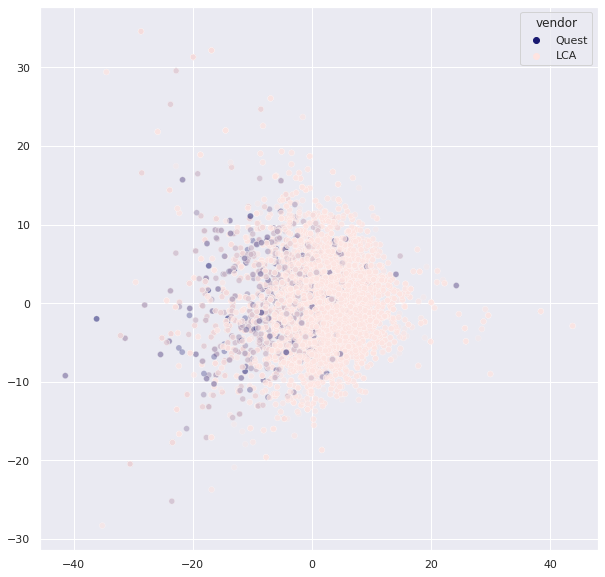

In [25]:
fig = plt.figure(figsize=(10, 10))
# sns.set(palette="deep")
sns.scatterplot(projected[:, 0], projected[:, 1], hue=final_merge['vendor'], alpha=0.3, palette=dict(Quest = 'midnightblue', LCA = 'mistyrose'))
fig.savefig('PCA_v1.png')